## Cyclic ID Algorithm Implementation with Examples

##### Based on: Forré & Mooij (2019) - "Causal Calculus in the Presence of Cycles, Latent Confounders and Selection Bias"

**Paper Link:** [arXiv:1901.00433](https://arxiv.org/abs/1901.00433) | [PDF](https://arxiv.org/pdf/1901.00433.pdf)


### 1. Introduction & Setup

#### 1.1 Why do we need an algorithm for Cyclic Graphs?

Traditional causal inference methods assume **acyclic graphs (DAGs)**, which have no feedback loops allowed in them. However, more realistic systems and networks often do include these cycles. Some examples include:

* Gene regulatory networks (GRNs): Gene X activates gene Y, which activates gene Z, which feeds back to activate gene X again. 

* Economic systems: Interest rates affect inflation, which affects interest rates.

* Neural networks: Recurrent connections create feedback loops.

The implementation of this **generalized ID** algorithm for input-output Structural Causal Models (ioSCMs) handles:

* Cycles (feedback loops)

* Latent confounders (unmeasured causes)

* Arbitrary probability distributions


#### 1.2 Key Question

Given a directed mixed graph $G$ with cycles, observational data $P(V)$ and a causal query: "What is $P(Y | \text{do}(X))$?

The main question we ask with this algorithm is ***can we identify the causal effect $P(Y | \text{do}(X))$ from the observational distribution $P(V)$ alone?***

The **generalized ID algorithm** answers this question for cyclic graphs. 


In [12]:
# importing packages and y0 module

from IPython.display import Markdown, display

from y0.algorithm.ioscm.utils import (
    get_apt_order,
    get_consolidated_district,
    get_graph_consolidated_districts,
    get_strongly_connected_components,
    get_vertex_consolidated_district,
    is_apt_order,
)
from y0. dsl import P, Variable
from y0.graph import NxMixedGraph

#### 1.3 Example Graphs to Demonstrate the Need for this algorithm

Here are two examples that illustrate why we need cyclic identification. 

#### Example 1: Simple Feedback Loop

A simple non-identifiable cyclic structure:

<div align="center">
    <img src="./feedback_loop1.png" alt="Feedback Loop Simple Graph Example" width="400">
</div>


**This is an example of the simplest cyclic structure. Two variables that affect each other simultaneously.**

- **Graph structure:** $x \rightarrow y$ and $y \rightarrow x$
- **Strongly Connected Component:** {x, y} form one SCC since each can reach the other.


**The fundamental problem:** 
When we observe data P(x,y), we see their joint behavior under the feedback loop. But if we want to answer the causal question "What happens to y if I intervene and set x to a specific value?" - we need P(y | do(x)). 

**Key Question:** Can we identify P(y | do(x)) from observational data P(x,y) alone?

#### Example 2: More Complex Graph: Cycles and Confounders

<div align="center">
    <img src="./graph 2 with confounders.png" alt="Example Graph with Confounders" width="400">
</div>

**Complex cyclic structure with hidden causes:**

- **Directed cycle:** x → y → z → x (feedback loop)
- **Latent confounder:** x ↔ z (unmeasured common cause U)
- **Key challenges:** This graph has both feedback AND unmeasured confounding
- **Identifiable?** This depends on the structure; the generalized ID algorithm determines if this kind of graph is identifiable or not. (Success or Fail)

### 2. Working Examples: Using a Directed Mixed Graph (DMG) 

For this specific implementation, we will walkthrough the cyclic ID algorithm using a directed mixed graph (DMG) that exhibits some key challenges:

1. **Cycles** (feedback loops)
2. **Latent confounders** (unmeasured common causes)
3. **Self-loops**

#### 2.1 Graph Structure - Success Case with 1 District

<div align="center">
    <img src="./DMG_example_1success.png" alt="Example DMG with cycles and self-loops" width="400">
</div>

This example graph contains:

**Variables:** {𝒳, 𝒴, 𝒵, 𝒲}

**Directed edges:**
- 𝒲 → 𝒳 (external input - potential intervention variable)
- 𝒳 → 𝒳 (self-loop - auto-regulatory feedback)
- 𝒳 → 𝒴 (forward edge)
- 𝒴 → 𝒵 (forward edge)
- 𝒵 → 𝒳 (feedback edge - completes 3-node cycle)

**Key structural features:**
1. **3-node cycle:** 𝒳 → 𝒴 → 𝒵 → 𝒳 (feedback loop)
2. **Self-loop:** 𝒳 → 𝒳 (auto-regulation)
3. **External input:** 𝒲 → 𝒳 (entry point for interventions)
4. **No latent confounders** in this version (makes it identifiable)

**Causal Query:** Can we identify P(𝒴 | do(𝒲))? 
- **Effect:** How does intervening on 𝒲 affect outcome 𝒴?
- **Expected Result:** SUCCESS ✓ (the algorithm will identify this effect)


**Note:** We will start with an **identifiable (SUCCESS)** case to understand how the algorithm works step-by-step. In further sections we will do a partially identifiable case, and a failure case. 


Graph structure (success case):

Nodes: ['w', 'x', 'y', 'z']

Directed Edges: (5)
  w -> x
  x -> x
  x -> y
  y -> z
  z -> x

Bidirected Edges: (0)


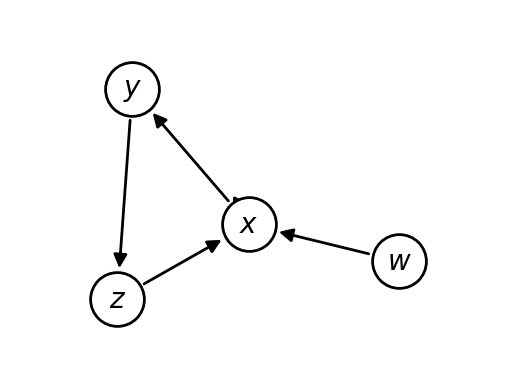

In [77]:
# Creating a success case graph to demonstrate the algorithm

from y0.dsl import Variable
from y0.graph import NxMixedGraph

# define the variables needed
x = Variable("x")
y = Variable("y")
z = Variable("z")
w = Variable("w")

# initialize the DMG (directed mixed graph)

graph_case_success = NxMixedGraph()

# add the directed edges
graph_case_success.add_directed_edge(w, x) # w -> x
graph_case_success.add_directed_edge(x, x) # x -> x (self-loop)
graph_case_success.add_directed_edge(x, y) # x -> y
graph_case_success.add_directed_edge(y, z) # y -> z
graph_case_success.add_directed_edge(z, x) # z -> x (completes the cycle)

# display the graph structure
print("Graph structure (success case):")
print(f"\nNodes: {sorted([str(n) for n in graph_case_success.nodes()])}")

print(f"\nDirected Edges: ({len(list(graph_case_success.directed.edges()))})")
for edge in sorted(graph_case_success.directed.edges(), key=lambda e: (str(e[0]), str(e[1]))):
    print(f"  {edge[0]} -> {edge[1]}")
    
print(f"\nBidirected Edges: ({len(list(graph_case_success.undirected.edges()))})")

# drawing the graph to visualize 
graph_case_success.draw()



#### 2.2 Algorithm Execution

##### Line 1: Function Declaration

**Algorithm:**
```
function ID(G, Y, W, P(V | do(J)))
```

**What this line does:** 
Declares the ID function with its inputs.

**Our specific inputs:**
- `G` = graph_case_success (our DMG)
- `Y` = {y} (target variable)
- `W` = {w} (intervention variable)
- `J` = ∅ (no background interventions)
- `P(V | do(J))` = P(V) (observational distribution, assuming we have data)

> **For detailed explanation of each parameter**, see the Explanation Notebook Line 1.

Let's set up our inputs in code:


In [39]:
# This cell is setting up the cyclic ID algorithm inputs

# Using the graph creeated in Section 2.1
G = graph_case_success

# Define our causal query
Y = {y}  # Target: we want to know the effect on y
W = {w}  # Intervention: we're intervening on w
J = set()  # No background interventions (empty set)

# Display our setup
print("=" * 60)
print("Algorithm 1: ID Function - Line 1")
print("=" * 60)
print(f"\nGraph G:")
print(f"   Nodes: {sorted([str(v) for v in G.nodes()])}")
print(f"   Edges: {len(list(G.directed.edges()))} directed")

print(f"\nCausal Query Setup:")
print(f"   Y (target):       {{{', '.join(str(v) for v in Y)}}}")
print(f"   W (intervention): {{{', '.join(str(v) for v in W)}}}")
print(f"   J (background):   {J if J else '∅ (empty)'}")

print(f"\nQuestion: Can we identify P(Y | do(W))?")
print(f"   In plain English: What is the causal effect of intervening")
print(f"   on {list(W)[0]} on the outcome {list(Y)[0]}?")
print("\n" + "=" * 60)

Algorithm 1: ID Function - Line 1

Graph G:
   Nodes: ['w', 'x', 'y', 'z']
   Edges: 5 directed

Causal Query Setup:
   Y (target):       {y}
   W (intervention): {w}
   J (background):   ∅ (empty)

Question: Can we identify P(Y | do(W))?
   In plain English: What is the causal effect of intervening
   on w on the outcome y?



##### Line 2: Precondition Checks

**Algorithm:**
```
require: Y ⊆ V, W ⊆ V, Y ∩ W = ∅
```
**What this line does:** 
Validates that the inputs are valid before proceeding with the algorithm.

If any condition fails, the algorithm terminates immediately. Let's verify these conditions for our example:


In [40]:
# This cell covers Line 2 of the algorithm to check the preconditions

V = set(G.nodes()) # all observed variables in the graph since this algorithm takes only observed variables

print("=" * 60)
print("Algorithm 1: ID Function - Line 2")
print("=" * 60)

# Check 1: Is Y a subset of V? (target variables are in graph)
check1 = Y.issubset(V)
print(f"\n✓ Check 1: Y ⊆ V (targets must be in graph)")
print(f"   Y = {{{', '.join(str(v) for v in sorted(Y, key=str))}}}")
print(f"   V = {{{', '.join(str(v) for v in sorted(V, key=str))}}}")
print(f"   Y ⊆ V? {check1} {'✓ PASS' if check1 else '✗ FAIL'}")

# Check 2: Is W a subset of V? (intervention variables are in graph)
check2 = W.issubset(V)
print(f"\n✓ Check 2: W ⊆ V (interventions must be in graph)")
print(f"   W = {{{', '.join(str(v) for v in sorted(W, key=str))}}}")
print(f"   V = {{{', '.join(str(v) for v in sorted(V, key=str))}}}")
print(f"   W ⊆ V? {check2} {'✓ PASS' if check2 else '✗ FAIL'}")

# Check 3: Y ∩ W = ∅
intersection = Y.intersection(W)
check3 = len(intersection) == 0
print(f"\n✓ Check 3: Y ∩ W = ∅ (no overlap allowed")
if intersection:
    print(f"   Y ∩ W = {{{', '.join(sorted([str(v) for v in intersection], key=str))}}}")
else:
    print(f"   Y ∩ W = ∅ (empty)")
print(f"   Disjoint? {check3} {'✓ PASS' if check3 else '✗ FAIL'}")
    
# Overall result
all_checks_pass = check1 and check2 and check3
print(f"\n{'='*60}")
if all_checks_pass:
    print("All preconditions satisfied")
    print("   → Can proceed to Line 3.")
else:
    print("Preconditions failed. Algorithm cannot proceed.")
print("=" * 60)



Algorithm 1: ID Function - Line 2

✓ Check 1: Y ⊆ V (targets must be in graph)
   Y = {y}
   V = {w, x, y, z}
   Y ⊆ V? True ✓ PASS

✓ Check 2: W ⊆ V (interventions must be in graph)
   W = {w}
   V = {w, x, y, z}
   W ⊆ V? True ✓ PASS

✓ Check 3: Y ∩ W = ∅ (no overlap allowed
   Y ∩ W = ∅ (empty)
   Disjoint? True ✓ PASS

All preconditions satisfied
   → Can proceed to Line 3.


Note: Since the preconditions have all passed, this means the algorithm can continue on to the further steps to identify the causal effects.

##### Line 3 - Computing the Ancestral Closure H

**Algorithm:**
```
H ← Anc^(G_(V\W))(Y)
```
**What this line does:**
Computes the **ancestral closure** of target variables Y after removing intervention variables W from the graph.

**Two-step process:**
1. **Graph surgery**: Create mutilated graph `G_(V\W)` by removing all nodes in W
2. **Find ancestors**: Compute all ancestors of Y in the mutilated graph

**Why this matters:**
Variables that are not ancestors of Y (after removing W) are irrelevant for identifying the causal effect. This step focuses the algorithm on only the causally relevant variables.

Let's compute H for our example:

In [41]:
# This cell will demonstrate how to compute the ancestral closure H

print("=" * 60)
print("Algorithm 1: Line 3 - Compute Ancestral Closure H")
print("=" * 60)


# step 1: Graph surgery - remove W and its outgoing edges
print(f"\nStep 1: Graph Surgery")
print(f"   Original nodes V: {sorted([str(v) for v in V], key=str)}")
print(f"   Remove W: {{{', '.join(sorted([str(v) for v in W], key=str))}}}")

# create a set of nodes to keep (V \ W)
V_minus_W = V - W
print(f"   Remaining (V\\W): {sorted([str(v) for v in V_minus_W], key=str)}")

# create a mutilated graph by keeping only nodes in V \ W
G_mutilated = G.subgraph(V_minus_W)
print(f"   Mutilated graph: {len(G_mutilated.nodes())} nodes, {len(list(G_mutilated.directed.edges()))} directed edges")


# Step 2: Find ancestors of Y in the mutilated graph
print(f"\nStep 2: Find Ancestors of Y")
print(f"   Target Y = {{{', '.join(sorted([str(v) for v in Y], key=str))}}}")

# compute the ancestors for each variable in Y (union if multiple targets)
H = set()
for target in Y:
    ancestors = G_mutilated.ancestors_inclusive(target) # this function is called to get ancestors including the node itself
    print(f"   Ancestral Set: {target}: {{{', '.join(sorted([str(v) for v in ancestors], key=str))}}}")
    H.update(ancestors)
    
print(f"\n✓ Result: Ancestral Closure H")
print(f"   H = {{{', '.join(sorted([str(v) for v in H], key=str))}}}")
print(f"  |H| = {len(H)} variable(s)")

print(f"\nInterpretation:")
print(f"   Only these {len(H)} variable(s) are causally relevant for P(Y|do(W))")
if len(H) < len(V_minus_W):
    excluded = V_minus_W - H
    print(f"   Excluded: {{{', '.join(sorted([str(v) for v in excluded], key=str))}}} (not ancestors of Y)")
else:
    print(f"   All remaining variables are ancestors of Y")
print("=" * 60)


Algorithm 1: Line 3 - Compute Ancestral Closure H

Step 1: Graph Surgery
   Original nodes V: ['w', 'x', 'y', 'z']
   Remove W: {w}
   Remaining (V\W): ['x', 'y', 'z']
   Mutilated graph: 3 nodes, 4 directed edges

Step 2: Find Ancestors of Y
   Target Y = {y}
   Ancestral Set: y: {x, y, z}

✓ Result: Ancestral Closure H
   H = {x, y, z}
  |H| = 3 variable(s)

Interpretation:
   Only these 3 variable(s) are causally relevant for P(Y|do(W))
   All remaining variables are ancestors of Y


**Visualizing Graph Surgery**

Below we show the mutilated graph G_{V\W} after removing the intervention variable W. This graph represents the causal structure we care about when computing the effect of do(W) on Y:



Comparison: Original vs Mutilated Graph


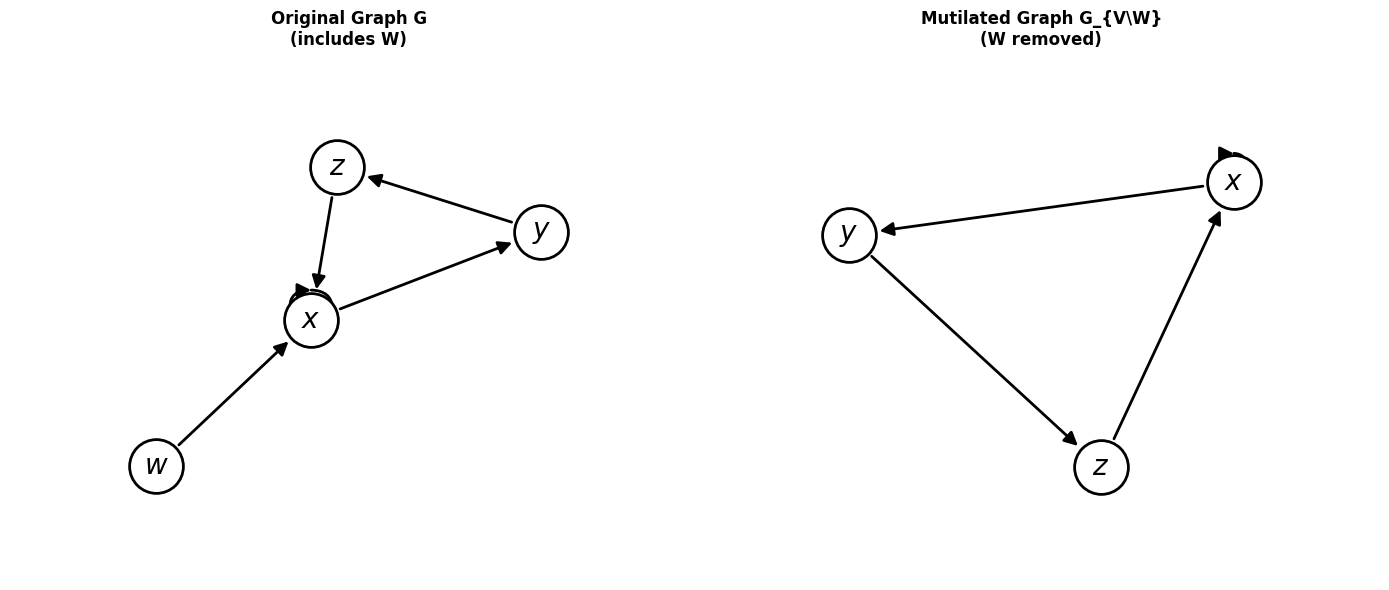


💡 Graph surgery removed W and its outgoing edge W → X


In [ ]:
import matplotlib.pyplot as plt

print("\nComparison: Original vs Mutilated Graph")
print("=" * 60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Original graph
plt.sca(ax1)
G.draw()
ax1.set_title("Original Graph G\n(includes W)", fontsize=12, fontweight='bold')

# Mutilated graph
plt.sca(ax2)
G_mutilated.draw()
ax2.set_title("Mutilated Graph G_{V\\W}\n(W removed)", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nGraph surgery removed W and its outgoing edge W → X")


#### Summary so far for Lines 1-3:

We've set up our causal query P(𝒴 | do(𝒲)) (Line 1), validated our inputs (Line 2), and computed the ancestral closure H = {𝒳, 𝒴, 𝒵} (Line 3). This tells us that all three variables are causally relevant for answering our query, which makes sense given the feedback loop 𝒳 → 𝒴 → 𝒵 → 𝒳 connecting them. The ancestral closure operation effectively focuses the algorithm on just these three variables, ignoring 𝒲 since we've already intervened on it. Next, we'll decompose H into consolidated districts to handle the cyclic structure.


##### Line 4 - Looping over Consolidated Districts

**Algorithm:**
```
for C ∈ CD(H) do
```

**What this line does:**

This line initiates a loop over all consolidated districs in the ancestral closure H that we found in the previous lines. Variables in the same consolidated district cannot be separated and must be identified together as a unit. The algorithm must process each consolidated district separately. If we can identify all districts, we can combine them (which is found in later lines in the algorithm) to identify the full causal effect.

Let's now compute the consolidated districts for H:

In [53]:
# This cell demonstrates computing the consolidated districts of H

from y0.algorithm.ioscm.utils import get_graph_consolidated_districts

print("=" * 60)
print("Algorithm 1: Line 4 - Loop over Consolidated Districts of H")
print("=" * 60)

# create the subgraph induced by H
H_subgraph = G_mutilated.subgraph(H) # using the mutilated graph from previous cell
print(f"\nInput: Ancestral closure H = {{{', '.join(sorted([str(v) for v in H], key=str))}}}")
print(f"Graph: {len(H_subgraph.nodes())} nodes, {len(list(H_subgraph.directed.edges()))} directed edges")

# compute the consolidated districts using the utility function
consolidated_districts_H = get_graph_consolidated_districts(H_subgraph)
print(f"\n✓ Consolidated Districts CD(H):")
print(f"   Number of districts: {len(consolidated_districts_H)}")

for i, district in enumerate(sorted(consolidated_districts_H, key=lambda d: sorted([str(v) for v in d])), 1):
    district_vars = sorted([str(v) for v in district], key=str)
    print(f"\n   District {i}: {{{', '.join(district_vars)}}}")
    print(f"      Size: {len(district)} variable(s)")
    
    # what makes this a district?
    if len(district) == 1:
        print(f"      Type: Single node (no coupling)")
    else:
        print(f"      Type: Multi-node district (coupled by cycles/confounders)")

    

Algorithm 1: Line 4 - Loop over Consolidated Districts of H

Input: Ancestral closure H = {x, y, z}
Graph: 3 nodes, 4 directed edges

✓ Consolidated Districts CD(H):
   Number of districts: 1

   District 1: {x, y, z}
      Size: 3 variable(s)
      Type: Multi-node district (coupled by cycles/confounders)


We computed the consolidated districts $CD(H)$ for our ancestral closure $H$ = {𝒳, 𝒴, 𝒵}. The result shows that **all three variables form one consolidated district**. This means they are tightly coupled together by the 3-node feedback loop (𝒳 → 𝒴 → 𝒵 → 𝒳) and cannot be decomposed into smaller independent pieces at this stage. The algorithm must identify this entire district as a single unit by calling the IDCD helper function. If we had multiple independent districts for example, we could process each one separately and combine the results; but here, the cyclic structure keeps everything coupled together in order to process the identification problem and break it into smaller pieces. 


##### Line 5 - Calling the IDCD Helper Function

For each consolidated district $D ∈ CD(H)$, we call the **IDCD (Identification in Consolidated Districts)** helper function.

**Implementation Status:**

The IDCD function is a recursive algorithm that deserves its own detailed implementation. ```TODO```

**For this walkthrough:** We'll note where IDCD gets called and continue to Lines 6-12 to understand the complete structure of the main ID algorithm.

### Line 6: Check if IDCD Returned FAIL

After calling IDCD for each district $D ∈ CD(H)$, we need to check if any district failed to be identified. If **any single district** returns FAIL, then the entire causal effect $P(Y | do(W))$ is **non-identifiable**.

**Logic:**
- If $Q[C]$ = FAIL for any district → return FAIL immediately (Line 7)
- If all districts succeed → continue to combine results (Lines 8-10)

**For our example:**
- We have 1 district: D = {𝒳, 𝒴, 𝒵}
- We would check: Did IDCD(G, C={}, D={x,y,z}, $Q[D]$) return FAIL?
- (We'll assume success for now since IDCD isn't implemented yet)

We can see how this works below:

In [67]:
# This cell checks if any district returned FAIL

print("=" * 60)
print("LINE 6: Check if any district returned FAIL")
print("=" * 60)

# Since IDCD isn't implemented yet, we'll simulate the check
# In actual implementation: for each D, check if IDCD returned None/FAIL

all_districts_identified = True  # Assume success for walkthrough

if not all_districts_identified:
    print("\nLine 7: At least one district returned Fail")
    print("   → The causal effect P(Y | do(W)) is not identifiable")
    print("   → Algorithm terminates with Fail")
else:
    print("\nAll districts successfully identified!")
    print("   → Continue to Lines 8-10 to combine district results")


LINE 6: Check if any district returned FAIL

All districts successfully identified!
   → Continue to Lines 8-10 to combine district results


### Lines 6-8: Check for IDCD Failure

After calling IDCD for each district D ∈ CD(H), we check if any returned FAIL.


**Note**: 

Q[C] represents the identification result for each district D.  
When combining multiple districts, we have Q[C]_D1, Q[C]_D2, etc.


**Line 6:** `if Q[C] = FAIL then`  
**Line 7:** `return FAIL`  
**Line 8:** `end if`

**For our SUCCESS case as an example:**
- All districts were successfully identified, so we continue on.
- The condition in Line 6 is **FALSE**
- We **skip Line 7** (no FAIL return)
- Line 8 closes the if statement
- We **continue in the loop** to process any remaining districts

The failure check happens **inside the loop** for each district. If any district fails, we immediately return FAIL and don't process remaining districts. For our single-district example, this check happens once.


**Note:**

This algorithm takes an all or nothing approach at this level. If one of the consolidated districts cannot be identified, the entire causal effect fails. This is because:

1. The causal effect involves all variables in H (the ancestral closure)
2. Variables are partitioned into districts
3. We need to identify **all** districts to recover the full effect
4. Missing one piece means we cannot compute $P(Y | do(W))$

This early failure check is computationally efficient; if any district is non-identifiable, we terminate immediately rather than continuing to process the remaining districts.

##### Line 9 - Ending the for loop

This closes the `for D ∈ CD(H) do` loop that started on Line 4.

**At this point in the code we can see:**
- We've exited the district processing loop
- All districts have been successfully identified
- Each district has its identification result $Q[C]$ stored
- Ready to combine the district results.

**For our example:**
- We processed 1 district: {𝒳, 𝒴, 𝒵}
- Result: $Q[C]$ (placeholder - depends on IDCD implementation)
- Next: Combine all $Q[C]$ values using tensor product

In [ ]:
print("=" * 60)
print("LINE 9: End For Loop")
print("=" * 60)

print(f"\nFinished processing all {len(consolidated_districts_H)} district(s)")

print(f"\nSummary of loop (Lines 4-9):")
print(f"   • Consolidated districts in CD(H): {len(consolidated_districts_H)}")
for i, D in enumerate(consolidated_districts_H, 1):
    print(f"   • District {i}: {sorted(D)} → R_D{i} identified ✓") # which means the result is identified and stored in Q[C]

LINE 9: End For Loop

Finished processing all 1 district(s)

Summary of loop (Lines 4-9):
   • Consolidated districts in CD(H): 1
   • District 1: [x, y, z] → R_D1 identified ✓


**Note**: 

Consolidated districts represent **independent pieces** of the causal structure (after accounting for latent confounders and cycles). The tensor product is the mathematical operation that combines independent probability distributions into a joint distribution.

For our single district case for this example, the tensor product simplifies to just keep $Q[C]$ as-is since the ⊗ of a single element is that element itself. At this point in the code, we now have $Q[H]$, which covers all variables in the ancestral closure.

In addition, we have now ended the for loop that started in Line 4 since we have the $Q[H]$, next we will handle the marginalization of $Q[H]$


##### Line 10: Computing Q[H] via Tensor Product

Now that all districts have been successfully identified (stored as $Q[C]$ for each $C ∈ CD(H)$), we combine them into a joint distribution $Q[H]$.

**Line 10:** `Q[H] ← ⊗_{C ∈ CD(H)} Q[C]`

**What this means:**
- Take the tensor product (⊗) of all district results 4Q[C]$
- This combines the identified distributions from each district
- The result is a joint distribution over all variables in H


**For our single-district example:**
- We have 1 district: C = {𝒳, 𝒴, 𝒵}
- $Q[H]$ = $Q[C]$ (tensor product of one element is just itself)
- No actual tensor product operation needed (for this example at least)

We can see this operation below:

In [ ]:
print("=" * 60)
print("LINE 10: Compute Q[H] via Tensor Product")
print("=" * 60)

print(f"\nConsolidated Districts: {len(consolidated_districts_H)} district(s)")
for i, C in enumerate(consolidated_districts_H, 1):
    print(f"   District {i}: C = {sorted(C)}")

if len(consolidated_districts_H) == 1:
    print(f"\n   Single district case:")
    print(f"   Q[H] = Q[C]")
    print(f"   (No tensor product operation needed - one element)")
    # In actual implementation: Q_H = district_results[list(consolidated_districts)[0]]
    
else:
    print(f"\n   Multiple districts - computing tensor product:")
    # In actual implementation:
    # Q_H = district_results[first_district]
    # for C in remaining_districts:
    #     Q_H = tensor_product(Q_H, district_results[C])
    for i, C in enumerate(consolidated_districts_H, 1):
        operator = "⊗" if i > 1 else " "
        print(f"   {operator} Q[C{i}] (district {sorted(C)})")
        
        
print(f"\nResult: Q[H] is joint distribution over H = {sorted(H)}")
print(f"\nNote: Actual formula depends on IDCD results (Line 5)")

LINE 10: Compute Q[H] via Tensor Product

Consolidated Districts: 1 district(s)
   District 1: C = [x, y, z]

   Single district case:
   Q[H] = Q[C]
   (No tensor product operation needed - one element)


##### Line 11 Marginalize to Target Variables


This line returns the final identified causal effect by marginalizing Q[H] to just the target variables Y.

**What this means:**
- P̃(Y | do(J, W)) is the **identified expression** for our causal query
- ∫ dx_{H\Y} means integrate (marginalize) over all variables in H\Y
- This gives us P(Y | do(W)) expressed in terms of observational distributions

**For our example:**
- Query: P(Y | do(W)) where Y = {𝒴}, W = {𝒲}, J = ∅
- H\Y = {𝒳, 𝒵}
- Result: P̃(𝒴 | do(𝒲)) = ∫∫ Q[H](x, y, z) dx dz


We can see this operation below:

In [73]:
print("=" * 60)
print("LINE 11: Return Final Result")
print("=" * 60)

print("\nOriginal Query:")
print(f"   Can we identify P(Y | do(W))?")
print(f"   Y = {sorted(Y)}")
print(f"   W = {sorted(W)}")
print(f"   J = {sorted(J)} (background interventions)")

Y_str = sorted([str(v) for v in Y])
W_str = sorted([str(v) for v in W])
H_str = sorted([str(v) for v in H])

# Compute marginalization variables
marginalize_out = H - Y
marginalize_out_str = sorted([str(v) for v in marginalize_out])

print("\nALGORITHM RESULT: Identifiable")

print(f"\nIdentified Expression:")
print(f"   P̃(Y | do(J, W)) = ∫ Q[H] dx_{{H\\Y}}")

if len(marginalize_out) > 0:
    print(f"\n   Specifically:")
    print(f"   P̃({', '.join(sorted(Y_str))} | do({', '.join(sorted(W_str))})) = ∫ Q[{', '.join(sorted(H_str))}] d{' d'.join(marginalize_out_str)}")
    print(f"\n   In words: Integrate Q[H] over {marginalize_out_str}")
else:
    print(f"\n   P̃(Y | do(W)) = Q[H] (no marginalization needed)")




LINE 11: Return Final Result

Original Query:
   Can we identify P(Y | do(W))?
   Y = [y]
   W = [w]
   J = [] (background interventions)

ALGORITHM RESULT: Identifiable

Identified Expression:
   P̃(Y | do(J, W)) = ∫ Q[H] dx_{H\Y}

   Specifically:
   P̃(y | do(w)) = ∫ Q[x, y, z] dx dz

   In words: Integrate Q[H] over ['x', 'z']


**Understanding the Output:**

The output confirms that P(𝒴 | do(𝒲)) is **identifiable**, meaning we can compute the causal effect from observational data without experiments. The formula structure P̃(y | do(w)) = ∫ Q[x, y, z] dx dz tells us to first compute the joint distribution over all three variables in the feedback loop (𝒳, 𝒴, 𝒵), then sum over x and z to extract just the effect on 𝒴. The actual formula would come from the IDCD output, which still needs to be computed. 